In [1]:
from sympy import sin, cos, symbols, diff, Matrix
from sympy import solve, simplify
from sympy.physics.mechanics import *
from sympy import Rational
import math
init_vprinting()

# System Description

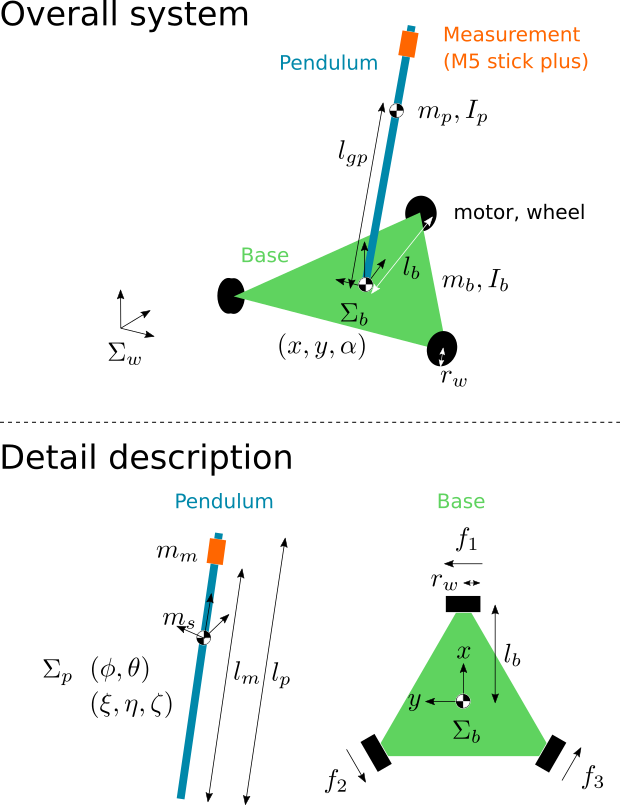

In [2]:
from IPython.display import Image
Image(filename='pictures/modelling.png', width=400)

## coordinate frames

In [3]:
Sw = ReferenceFrame('Sw')
Sb = ReferenceFrame('Sb')
Sptmp = ReferenceFrame('Sptmp')
Sp = ReferenceFrame('Sp')
Sm2 = ReferenceFrame('Sm2')
Sm3 = ReferenceFrame('Sm3')

### general

In [4]:
t, g, pi = symbols('t g pi')

### base

In [5]:
mb, lb, rw = symbols('m_b l_b r_w')
Ibxx, Ibyy, Ibzz = symbols('I_{bxx} I_{byy} I_{bzz}')
Ib = inertia(Sb, Ibxx, Ibyy, Ibzz)

x, y, alpha = dynamicsymbols('x y alpha')

### pendulum

In [6]:
mp, lp = symbols('m_p l_p')
#ms, mm, mp, lgp, lp, lm = symbols('m_s m_m m_p l_{gp} l_p l_m') # full description
Ipxx, Ipyy, Ipzz = symbols('I_{pxx} I_{pyy} I_{pzz}')
Ipxx = Rational(1,12)*mp*lp**2
Ip = inertia(Sp, Ipxx, Ipxx, 0)

phi, theta = dynamicsymbols('phi theta')

### motor

In [7]:
f1, f2, f3 = dynamicsymbols('f1 f2 f3')

## state

In [8]:
q = Matrix([x, y, alpha, phi, theta])
qd = q.diff(t)

# Basic Calculation

## coordinates transformation

In [9]:
Sb.orient(Sw, 'Axis', [alpha, Sw.z])

Sptmp.orient(Sw, 'Axis', [phi, Sw.x]);
Sp.orient(Sptmp, 'Axis', [theta, Sptmp.y]);
#Sp.set_ang_vel(Sw, phi.diff(t)*cos(theta)*Sw.x + theta.diff(t)*Sw.y + sin(theta)*phi.diff(t)*Sw.z) # omega
#display(Sp.ang_vel_in(Sw))

## point

### world

In [10]:
Pwo = Point('Pwo')
Pwo.set_vel(Sw, 0)

### body

In [11]:
Pbo = Point('Pbo')
Pbo.set_pos(Pwo, x*Sw.x + y*Sw.y + 0*Sw.z)
Pbo.set_vel(Sw, Pbo.pos_from(Pwo).dt(Sw))

### pendulum

In [12]:
Ppo = Point('Ppo')
Ppo.set_pos(Pwo, x*Sw.x + y*Sw.y + Rational(1,2)*lp*Sp.z)
#Ppo.set_pos(Pwo, Rational(1,2)*lp*Sp.z) # only pendulum case: just for debug
Ppo.set_vel(Sw, Ppo.pos_from(Pwo).dt(Sw))

### motor

In [13]:
Sm1 = Sb
Pm1 = Point("Pm1")
Pm1.set_pos(Pbo, lb*Sm1.x + 0*Sm1.y + 0*Sm1.z)

Sm2.orient(Sb, 'Axis', [Rational(2, 3)*pi, Sb.z])
Pm2 = Point("Pm2")
Pm2.set_pos(Pbo, lb*Sm2.x + 0*Sm2.y + 0*Sm2.z)

Sm3.orient(Sb, 'Axis', [Rational(4, 3)*pi, Sb.z])
Pm3 = Point("Pm3")
Pm3.set_pos(Pbo, lb*Sm3.x + 0*Sm3.y + 0*Sm3.z)

## register RigidBody

In [14]:
BodyB = RigidBody('BodyB', Pbo, Sb, mb, (Ib, Pbo))
BodyP = RigidBody('BodyP', Ppo, Sp, mp, (Ip, Ppo))

## potential energy

In [15]:
p_cog_pos = (Ppo.pos_from(Pwo).express(Sw)).simplify()
display(p_cog_pos)

BodyP.potential_energy = mp * g * Rational(1,2) * lp * cos(phi) * cos(theta);

## force from wheels

In [16]:
fl1 = (Pm1, f1*Sm1.y)
fl2 = (Pm2, f2*Sm2.y)
fl3 = (Pm3, f3*Sm3.y)
fl = [fl1, fl2, fl3]

# Lagrangian

## equation of motion

In [17]:
LL = Lagrangian(Sw, BodyB, BodyP)
LM = LagrangesMethod(LL, q, forcelist = fl, frame = Sw)

eom = simplify(LM.form_lagranges_equations())
f = simplify(LM.rhs())
display(eom)
display(f)

⎡                                                   ⎛             2                    ⎞           
⎢                                                mₚ⋅⎝- lₚ⋅sin(θ)⋅θ̇  + lₚ⋅cos(θ)⋅θ̈ + 2⋅ẍ⎠        
⎢                                        m_b⋅ẍ + ─────────────────────────────────────── + f₁⋅sin(
⎢                                                                   2                              
⎢                                                                                                  
⎢           ⎛                                       2                     2                        
⎢        mₚ⋅⎝lₚ⋅sin(φ)⋅sin(θ)⋅θ̈ + lₚ⋅sin(φ)⋅cos(θ)⋅φ̇  + lₚ⋅sin(φ)⋅cos(θ)⋅θ̇  + 2⋅lₚ⋅sin(θ)⋅cos(φ)
⎢m_b⋅ÿ + ─────────────────────────────────────────────────────────────────────────────────────────
⎢                                                                   2                              
⎢                                                                                                  


⎡                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  
⎢                                                                                                  


## linearization

In [18]:
linearizer = LM.to_linearizer(q_ind=q, qd_ind=qd)
op_point = {x: 0, x.diff(t): 0, y: 0, y.diff(t): 0, alpha: 0, alpha.diff(t): 0,
            phi: 0, phi.diff(t): 0, theta: 0, theta.diff(t): 0,
            f1: 0, f2: 0, f3: 0}
A, B = linearizer.linearize(A_and_B = True, op_point = op_point)

display(simplify(A))
display(simplify(B))

⎡0  0  0         0                0         1  0  0  0  0⎤
⎢                                                        ⎥
⎢0  0  0         0                0         0  1  0  0  0⎥
⎢                                                        ⎥
⎢0  0  0         0                0         0  0  1  0  0⎥
⎢                                                        ⎥
⎢0  0  0         0                0         0  0  0  1  0⎥
⎢                                                        ⎥
⎢0  0  0         0                0         0  0  0  0  1⎥
⎢                                                        ⎥
⎢                               3⋅g⋅mₚ                   ⎥
⎢0  0  0         0           ───────────    0  0  0  0  0⎥
⎢                            -4⋅m_b - mₚ                 ⎥
⎢                                                        ⎥
⎢             3⋅g⋅mₚ                                     ⎥
⎢0  0  0    ──────────            0         0  0  0  0  0⎥
⎢           4⋅m_b + mₚ                                  

⎡       0                0                0       ⎤
⎢                                                 ⎥
⎢       0                0                0       ⎥
⎢                                                 ⎥
⎢       0                0                0       ⎥
⎢                                                 ⎥
⎢       0                0                0       ⎥
⎢                                                 ⎥
⎢       0                0                0       ⎥
⎢                                                 ⎥
⎢                         ⎛2⋅π⎞            ⎛4⋅π⎞  ⎥
⎢                    4⋅sin⎜───⎟       4⋅sin⎜───⎟  ⎥
⎢                         ⎝ 3 ⎠            ⎝ 3 ⎠  ⎥
⎢       0           ───────────      ───────────  ⎥
⎢                   -4⋅m_b - mₚ      -4⋅m_b - mₚ  ⎥
⎢                                                 ⎥
⎢                        ⎛2⋅π⎞            ⎛4⋅π⎞   ⎥
⎢                   4⋅cos⎜───⎟       4⋅cos⎜───⎟   ⎥
⎢      4                 ⎝ 3 ⎠            ⎝ 3 ⎠   ⎥
⎢  ─────────

In [19]:
# only pendulum case: just for debug
#q = Matrix([phi, theta])
#qd = q.diff(t)
#LL = Lagrangian(Sw, BodyP)
#LM = LagrangesMethod(LL, q, forcelist = fl, frame = Sw)

#eom = LM.form_lagranges_equations().simplify()

#linearizer = LM.to_linearizer(q_ind=q, qd_ind=qd)
#op_point = {x: 0, x.diff(t): 0, y: 0, y.diff(t): 0, alpha: 0, alpha.diff(t): 0,
#            phi: 0, phi.diff(t): 0, theta: 0, theta.diff(t): 0,
#            f1: 0, f2: 0, f3: 0}
#A, B = linearizer.linearize(A_and_B = True, op_point = op_point)

#display(simplify(A))
#display(simplify(B))

# Verification

## energy derived from RigidBody

In [20]:
display(BodyB.kinetic_energy(Sw).simplify())
display(BodyB.potential_energy.simplify())

In [21]:
display(BodyP.kinetic_energy(Sw).simplify())
display(BodyP.potential_energy.simplify())

## energy derived from algebra

### rotation matrices

In [22]:
rotx_phi = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
roty_theta = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])

rot_op = rotx_phi * roty_theta
display(rot_op)

⎡    cos(θ)        0         sin(θ)    ⎤
⎢                                      ⎥
⎢sin(φ)⋅sin(θ)   cos(φ)  -sin(φ)⋅cos(θ)⎥
⎢                                      ⎥
⎣-sin(θ)⋅cos(φ)  sin(φ)  cos(φ)⋅cos(θ) ⎦

### cog position of pendulum

In [23]:
vec_p = Matrix([[0], [0], [Rational(1, 2)*lp]])
xi, eta, zeta = rot_op * vec_p

### angular velocity of pendulum

In [24]:
#omega_p = Matrix([[0], [theta.diff(t)], [0]]) + roty_theta.transpose() * Matrix([[phi.diff(t)], [0], [0]])
s_omega_p = simplify(rot_op.transpose() * rot_op.diff(t))

omega_p = Matrix([[s_omega_p[2,1]], [s_omega_p[0,2]], [s_omega_p[1,0]]])
display(omega_p)

⎡cos(θ)⋅φ̇⎤
⎢        ⎥
⎢   θ̇    ⎥
⎢        ⎥
⎣sin(θ)⋅φ̇⎦

In [25]:
inertia_mat = Matrix([[Ipxx, 0, 0], [0, Ipxx, 0], [0, 0, 0]])
display(inertia_mat)

⎡  2              ⎤
⎢lₚ ⋅mₚ           ⎥
⎢──────    0     0⎥
⎢  12             ⎥
⎢                 ⎥
⎢          2      ⎥
⎢        lₚ ⋅mₚ   ⎥
⎢  0     ──────  0⎥
⎢          12     ⎥
⎢                 ⎥
⎣  0       0     0⎦

In [26]:
Tpt = Rational(1, 2) * mp * ((x.diff(t) + xi.diff(t))**2 + (y.diff(t) + eta.diff(t))**2 + zeta.diff(t)**2)
Tpr = Rational(1, 2) * omega_p.transpose() * inertia_mat * omega_p

## comparison between RigidBody and algebraic calculation

### kinetic energy of pendulum

In [27]:
display(simplify(Tpt + Tpr[0, 0]))
display(BodyP.kinetic_energy(Sw).simplify())

display(simplify(Tpt + Tpr[0, 0]) - BodyP.kinetic_energy(Sw).simplify())

### Lagrangian

In [28]:
L_from_algebra = BodyB.kinetic_energy(Sw).simplify() + BodyP.kinetic_energy(Sw).simplify() - BodyP.potential_energy.simplify()
display(simplify(LL.simplify() - L_from_algebra))

# Simulation

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
%matplotlib inline

## physical parameter substitution

In [30]:
param_val = {g: 9.8, mb: 0.5, lb: 0.12, rw: 0.03, Ibzz: 0.0018, mp: 0.01, lp: 2.0, pi: 3.14}

f_sim = f.subs(param_val)
A_sim = np.array(A.subs(param_val), dtype=np.float64)
B_sim = np.array(B.subs(param_val), dtype=np.float64)

display(A_sim)
display(B_sim)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.14626866,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.14626866,  0.        ,
         0.        ,  0.        ,  0.        

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -1.72448915,  1.72131678],
       [ 1.99004975, -0.99319443, -0.99868241],
       [66.66666667, 66.66666667, 66.66666667],
       [ 1.49253731, -0.74489582, -0.7490118 ],
       [ 0.        ,  1.29336687, -1.29098759]])

## nonlinear system

In [31]:
def nonlinear_model(xn, un):
    sim_xn = {x: xn[0], y: xn[1], alpha: xn[2], phi: xn[3], theta: xn[4],
              qd[0]: xn[5], qd[1]: xn[6], qd[2]: xn[7], qd[3]: xn[8], qd[4]: xn[9]}
    sim_un = {f1: un[0], f2: un[1], f3: un[2]}
    ans_vec = np.zeros(10)
    for i in range(0, 10):
        ans_vec[i] = msubs(f_sim, sim_xn, sim_un).evalf()[i]
    
    return ans_vec

#test_vec = nonlinear_model([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1])
#display(test_vec)

## LQR controller

In [62]:
Q = 1*np.eye(10)
#Q[0,0] = 5     # phi
#Q[4,4] = 5     # theta
#Q[8,8] = 5     # dphi/dt
#Q[9,9] = 5     # dtheta/dt
R = 10*np.eye(3)
display(Q)

def solve_lqr(A_sim, B_sim, Q, R):
    P = linalg.solve_continuous_are(A_sim, B_sim, Q, R)
    K = linalg.inv(R).dot(B_sim.T).dot(P)
    E = linalg.eigvals(A_sim - B_sim.dot(K))
    
    return P, K, E

[P, K, E] = solve_lqr(A_sim, B_sim, Q, R)
display(E)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

array([-36.50113126+0.j        ,  -0.72204693+0.4850757j ,
        -0.72204693-0.4850757j ,  -0.72260761+0.48519362j,
        -0.72260761-0.48519362j,  -1.00037549+0.j        ,
        -3.02777184+0.j        ,  -3.0281806 +0.j        ,
        -2.47122456+0.j        ,  -2.47090258+0.j        ])

## execute simulation

In [33]:
T_sim  = 20
dt_sim = 0.02
x0_sim = np.array([0, 0, 0, 0.1, -0.1, 0, 0, 0, 0, 0])
u0_sim = np.array([0, 0, 0])

In [34]:
def execute_simulation(T_sim, dt_sim, x0_sim, u0_sim):
    t_sim = np.arange(0, T_sim, dt_sim)
    x_sim = np.zeros([len(t_sim), 10])
    u_sim = np.zeros([len(t_sim), 3])

    x_sim[0,:] = x0_sim
    u_sim[0,:] = u0_sim

    for i in range(1, len(t_sim)):
        u_sim[i] = -np.dot(K, x_sim[i-1,:])
        dx_sim = nonlinear_model(x_sim[i-1,:], u_sim[i,:])
        x_sim[i,:] = x_sim[i-1,:] + dx_sim * dt_sim
    
    return t_sim, x_sim, u_sim

[t_sim, x_sim, u_sim] = execute_simulation(T_sim, dt_sim, x0_sim, u0_sim)

## plot figures

### x, y, alpha

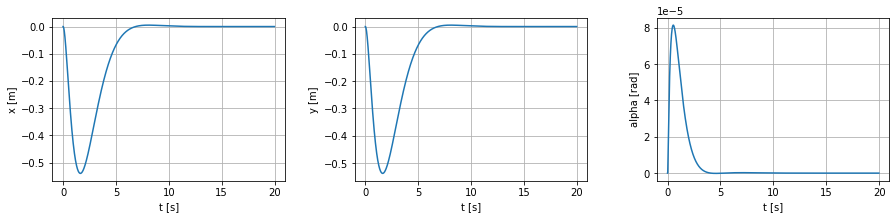

In [35]:
def plot_x_y_alpha(t_sim, x_sim):
    plt.figure(figsize=(15.0, 3.0))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.subplot(1, 3, 1)
    plt.xlabel("t [s]")
    plt.ylabel("x [m]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,0])

    plt.subplot(1, 3, 2)
    plt.xlabel("t [s]")
    plt.ylabel("y [m]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,1])

    plt.subplot(1, 3, 3)
    plt.xlabel("t [s]")
    plt.ylabel("alpha [rad]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,2])

    plt.savefig('pictures/xyalpha.png')

plot_x_y_alpha(t_sim, x_sim)

## phi, theta

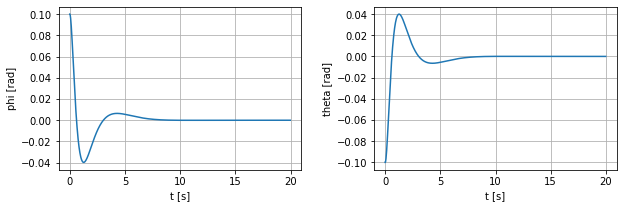

In [36]:
def plot_phi_theta(t_sim, x_sim):
    plt.figure(figsize=(10.0, 3.0))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.subplot(1, 2, 1)
    plt.xlabel("t [s]")
    plt.ylabel("phi [rad]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,3])

    plt.subplot(1, 2, 2)
    plt.xlabel("t [s]")
    plt.ylabel("theta [rad]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,4])

    plt.savefig('pictures/phitheta.png')

plot_phi_theta(t_sim, x_sim)

## dx/dt, dy/dt, dalpha/dt

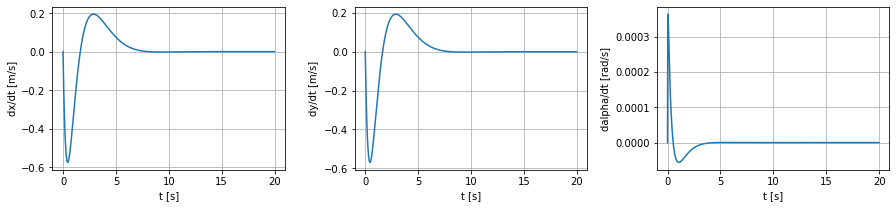

In [37]:
def plot_dx_dy_dalpha(t_sim, x_sim):
    plt.figure(figsize=(15.0, 3.0))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.subplot(1, 3, 1)
    plt.xlabel("t [s]")
    plt.ylabel("dx/dt [m/s]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,5])

    plt.subplot(1, 3, 2)
    plt.xlabel("t [s]")
    plt.ylabel("dy/dt [m/s]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,6])

    plt.subplot(1, 3, 3)
    plt.xlabel("t [s]")
    plt.ylabel("dalpha/dt [rad/s]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,7])

plot_dx_dy_dalpha(t_sim, x_sim)

## dphi/dt, dtheta/dt

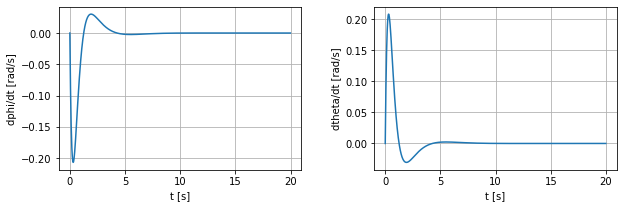

In [38]:
def plot_dphi_dtheta(t_sim, x_sim):
    plt.figure(figsize=(10.0, 3.0))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.subplot(1, 2, 1)
    plt.xlabel("t [s]")
    plt.ylabel("dphi/dt [rad/s]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,8])

    plt.subplot(1, 2, 2)
    plt.xlabel("t [s]")
    plt.ylabel("dtheta/dt [rad/s]")
    plt.grid(True)
    plt.plot(t_sim, x_sim[:,9])

plot_dphi_dtheta(t_sim, x_sim)

## input

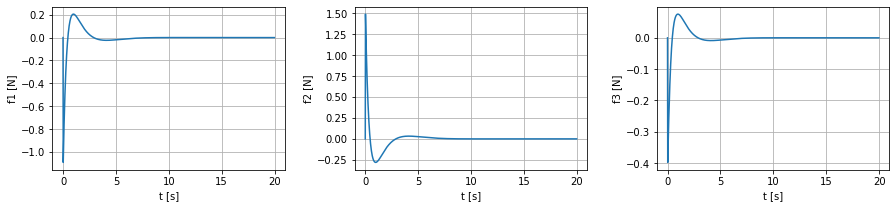

In [39]:
def plot_input(t_sim, u_sim):
    plt.figure(figsize=(15.0, 3.0))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.subplot(1, 3, 1)
    plt.xlabel("t [s]")
    plt.ylabel("f1 [N]")
    plt.grid(True)
    plt.plot(t_sim, u_sim[:,0])

    plt.subplot(1, 3, 2)
    plt.xlabel("t [s]")
    plt.ylabel("f2 [N]")
    plt.grid(True)
    plt.plot(t_sim, u_sim[:,1])

    plt.subplot(1, 3, 3)
    plt.xlabel("t [s]")
    plt.ylabel("f3 [N]")
    plt.grid(True)
    plt.plot(t_sim, u_sim[:,2])

    plt.savefig('pictures/input.png')

plot_input(t_sim, u_sim)

## LQR controller parameter consideration

### common setting

In [40]:
T_sim  = 20
dt_sim = 0.02
x0_sim = np.array([0, 0, 0, 0.1, -0.1, 0, 0, 0, 0, 0])
u0_sim = np.array([0, 0, 0])

### default controller

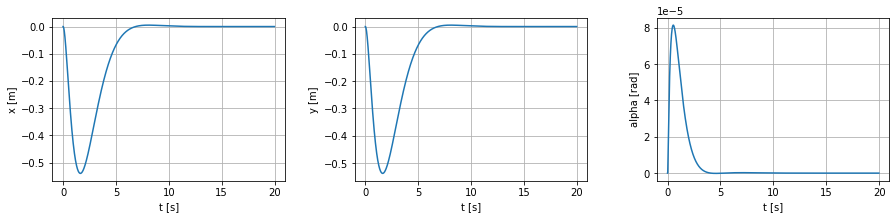

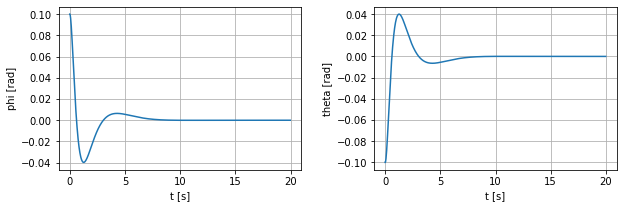

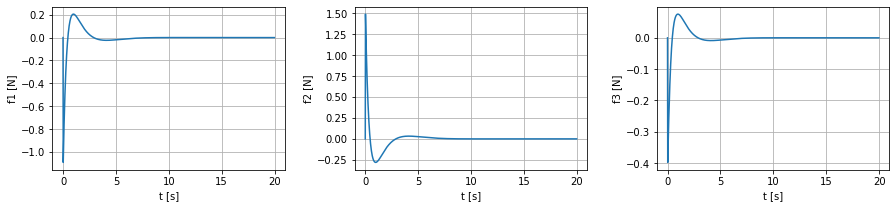

In [41]:
Q = 1*np.eye(10)
R = 10*np.eye(3)
[P, K, E] = solve_lqr(A_sim, B_sim, Q, R)

[t_sim, x_sim, u_sim] = execute_simulation(T_sim, dt_sim, x0_sim, u0_sim)

plot_x_y_alpha(t_sim, x_sim)
plot_phi_theta(t_sim, x_sim)
plot_input(t_sim, u_sim)

### x weighted case

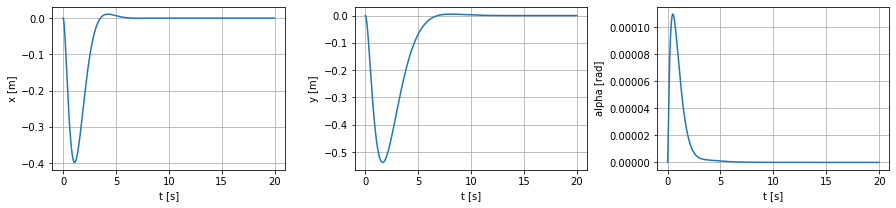

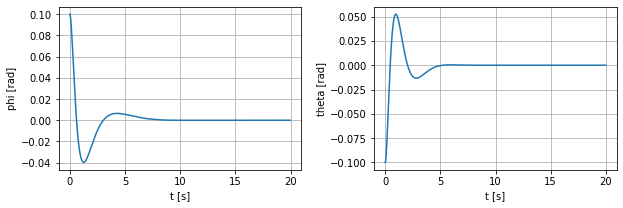

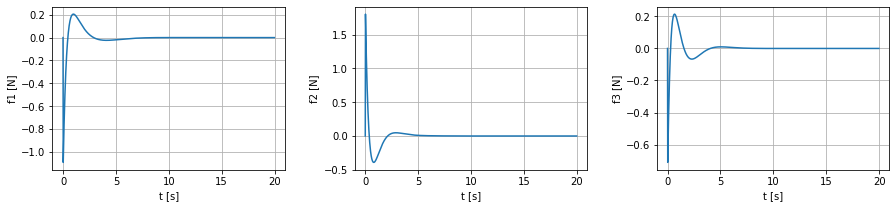

In [42]:
Q = 1*np.eye(10)
Q[0,0] = 10     # x
R = 10*np.eye(3)
[P, K, E] = solve_lqr(A_sim, B_sim, Q, R)

[t_sim, x_sim, u_sim] = execute_simulation(T_sim, dt_sim, x0_sim, u0_sim)

plot_x_y_alpha(t_sim, x_sim)
plot_phi_theta(t_sim, x_sim)
plot_input(t_sim, u_sim)

### u2 weighted case

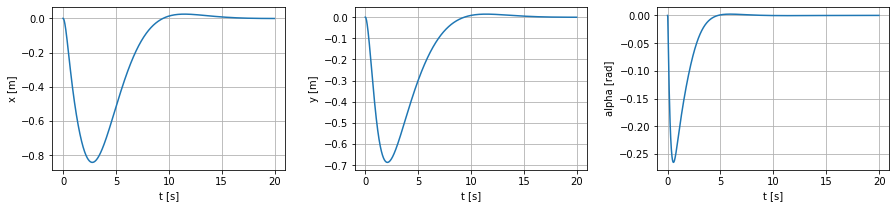

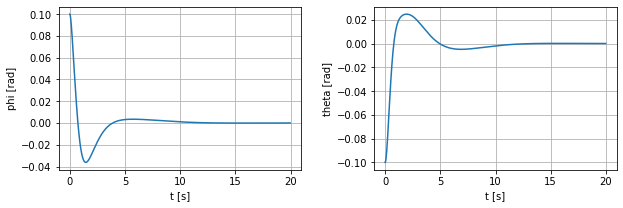

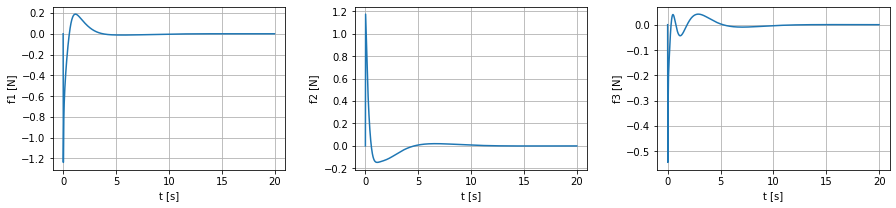

In [43]:
Q = 1*np.eye(10)
R = 10*np.eye(3)
R[1,1] = 100     # u2
[P, K, E] = solve_lqr(A_sim, B_sim, Q, R)

[t_sim, x_sim, u_sim] = execute_simulation(T_sim, dt_sim, x0_sim, u0_sim)

plot_x_y_alpha(t_sim, x_sim)
plot_phi_theta(t_sim, x_sim)
plot_input(t_sim, u_sim)

# Animation

In [44]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
from matplotlib import animation
import imageio

## mathematical definition of rotation matrix

In [45]:
def rot_x(theta):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(theta), -np.sin(theta)],
                   [0, np.sin(theta), np.cos(theta)]])
    return Rx;

def rot_y(theta):
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    return Ry;
    
def rot_z(theta):
    Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta), np.cos(theta), 0],
                   [0, 0, 1]])
    return Rz;

## physical parameter settings and define shapes

### base

In [46]:
lb_an = 0.2
a_an  = lb_an / 2 * 1.73
b_an  = lb_an / 2
h_an  = 0.05

In [47]:
def init_base_pos():
    base_pos = np.array([[lb_an, 0, 0],
                         [-b_an,  a_an, 0],
                         [-b_an, -a_an, 0],
                         [lb_an, 0, h_an],
                         [-b_an,  a_an, h_an],
                         [-b_an, -a_an, h_an]])
    
    return base_pos;

base_pos = init_base_pos();

In [48]:
base_vertex_num = 6

def rotate_base(base_pos, alpha):
    ans_pos = np.zeros((base_vertex_num, 3))
    for i in range(base_vertex_num):
        ans_pos[i] = rot_z(alpha).dot(base_pos[i])
        
    return ans_pos

def translate_base(base_pos, x, y):
    ans_pos = np.zeros((base_vertex_num, 3))
    for i in range(base_vertex_num):
        ans_pos[i] = [x, y, 0] + base_pos[i]
        
    return ans_pos

### pendulum

In [49]:
pa_an = 0.01
pl_an = 0.5

In [50]:
def init_pend_pos():
    pend_pos = np.array([[-pa_an, -pa_an, -pl_an],
                         [ pa_an, -pa_an, -pl_an],
                         [ pa_an,  pa_an, -pl_an],
                         [-pa_an,  pa_an, -pl_an],
                         [-pa_an, -pa_an, pl_an],
                         [ pa_an, -pa_an, pl_an],
                         [ pa_an,  pa_an, pl_an],
                         [-pa_an,  pa_an, pl_an]])

    return pend_pos

pend_pos = init_pend_pos()

In [51]:
pend_vertex_num = 8

def rotate_pend(pend_pos, phi, theta):
    ans_pos = np.zeros((pend_vertex_num, 3))
    for i in range(pend_vertex_num):
        ans_pos[i] = rot_y(theta).dot(rot_x(phi).dot(pend_pos[i]))
        
    return ans_pos

def adjust_pend_origin(pend_pos):
    ans_pos = np.zeros((pend_vertex_num, 3))
    origin_offset = (pend_pos[0] + pend_pos[2])/2
    robot_offset  = [0, 0, h_an]
    for i in range(pend_vertex_num):
        ans_pos[i] = -origin_offset + robot_offset + pend_pos[i]
        
    return ans_pos

def translate_pend(pend_pos, x, y):
    ans_pos = np.zeros((pend_vertex_num, 3))
    for i in range(pend_vertex_num):
        ans_pos[i] = [x, y, 0] + pend_pos[i]
        
    return ans_pos

## function for setting position and attitude

In [52]:
def set_base_pos(base_pos, x, y, alpha):
    base_pos = init_base_pos()
    base_pos = rotate_base(base_pos, alpha)
    base_pos = translate_base(base_pos, x, y)
    
    return base_pos

def set_pend_pos(pend_pos, x, y, phi, theta):
    pend_pos = init_pend_pos()
    pend_pos = rotate_pend(pend_pos, phi, theta)
    pend_pos = adjust_pend_origin(pend_pos)
    pend_pos = translate_pend(pend_pos, x, y)
    
    return pend_pos

## 3dplot function

In [53]:
def plot_pend_base(i, base_pos, pend_pos, is_movie):
    ax  = fig.add_subplot(111, projection='3d')
    base_surfs = [[base_pos[0],base_pos[1],base_pos[2]],
                  [base_pos[0],base_pos[2],base_pos[5],base_pos[3]],
                  [base_pos[0],base_pos[1],base_pos[4],base_pos[3]],
                  [base_pos[1],base_pos[2],base_pos[5],base_pos[4]],
                  [base_pos[3],base_pos[4],base_pos[5]]]
    ax.add_collection3d(Poly3DCollection(base_surfs, facecolors='green', linewidths=0.5, edgecolors='white', alpha=0.9))

    pend_surfs = [[pend_pos[0],pend_pos[1],pend_pos[2],pend_pos[3]],
                  [pend_pos[0],pend_pos[3],pend_pos[7],pend_pos[4]],
                  [pend_pos[1],pend_pos[2],pend_pos[6],pend_pos[5]],
                  [pend_pos[4],pend_pos[5],pend_pos[6],pend_pos[7]],
                  [pend_pos[0],pend_pos[1],pend_pos[5],pend_pos[4]],
                  [pend_pos[3],pend_pos[2],pend_pos[6],pend_pos[7]]]
    ax.add_collection3d(Poly3DCollection(pend_surfs, facecolors='blue', linewidths=0.5, edgecolors='white', alpha=0.9))
    
    ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax.set_zticks([0.0, 0.5, 1.0])
    
    if is_movie == True:
        plt.savefig('pictures/animation/image/img_' + str(i) + '.png')
    else:
        plt.show()

## test 3d plot

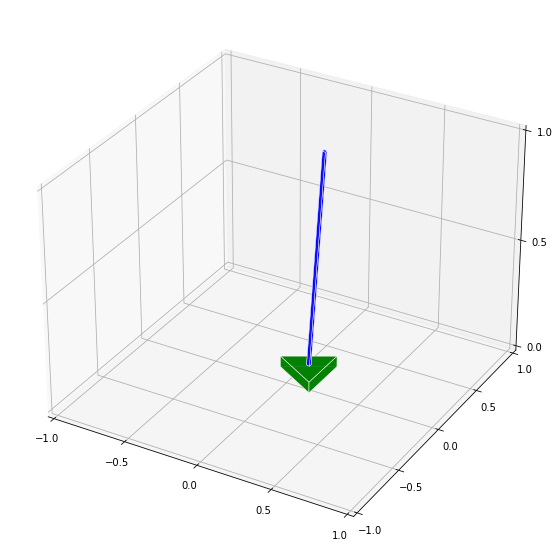

In [54]:
alpha_an = 3.14
x_pos_an = 0.1
y_pos_an = 0.1
phi_an   = 0.0
theta_an = 0.1

base_pos = set_base_pos(base_pos, x_pos_an, y_pos_an, alpha_an)
pend_pos = set_pend_pos(pend_pos, x_pos_an, y_pos_an, phi_an, theta_an)

fig = plt.figure(figsize=(10.0, 10.0))
plot_pend_base(0, base_pos, pend_pos, False)

## create simulation data for brief animation

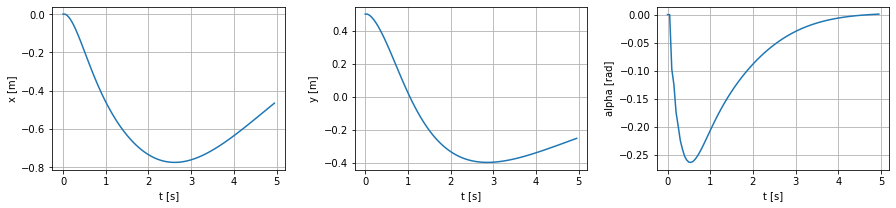

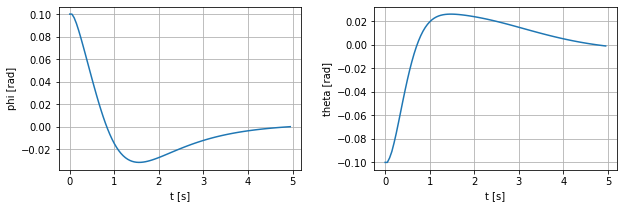

In [55]:
T_sim  = 5
dt_sim = 0.05
x0_sim = np.array([0, 0.5, 0.0, 0.1, -0.1, 0, 0, 0, 0, 0])
u0_sim = np.array([0, 0, 0])

[t_sim, x_sim, u_sim] = execute_simulation(T_sim, dt_sim, x0_sim, u0_sim)
plot_x_y_alpha(t_sim, x_sim)
plot_phi_theta(t_sim, x_sim)

## create animation images

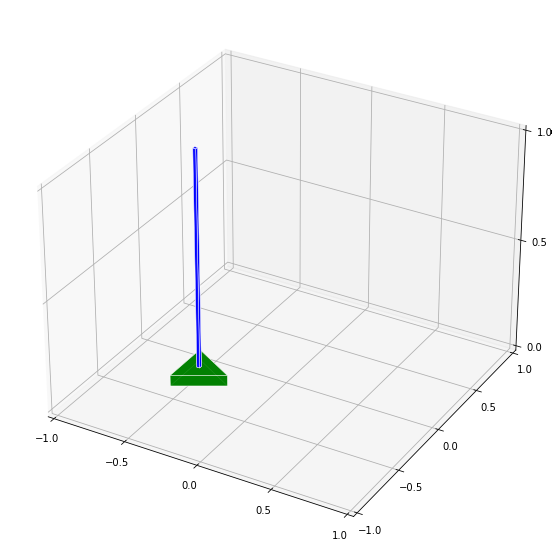

In [56]:
ims = []

fig = plt.figure(figsize=(10.0, 10.0))
for i in range(len(t_sim)):
    x_pos_an = x_sim[i, 0]
    y_pos_an = x_sim[i, 1]
    alpha_an = x_sim[i, 2]
    phi_an   = x_sim[i, 3]
    theta_an = x_sim[i, 4]
    
    base_pos = set_base_pos(base_pos, x_pos_an, y_pos_an, alpha_an)
    pend_pos = set_pend_pos(pend_pos, x_pos_an, y_pos_an, phi_an, theta_an)
    plot_pend_base(i, base_pos, pend_pos, True)

## save as a gif file and display

In [57]:
images = []
for i in range(len(t_sim)):
    images.append(imageio.imread('pictures/animation/image/img_' + str(i) + '.png'))

imageio.mimsave('pictures/animation/test1.gif', images)

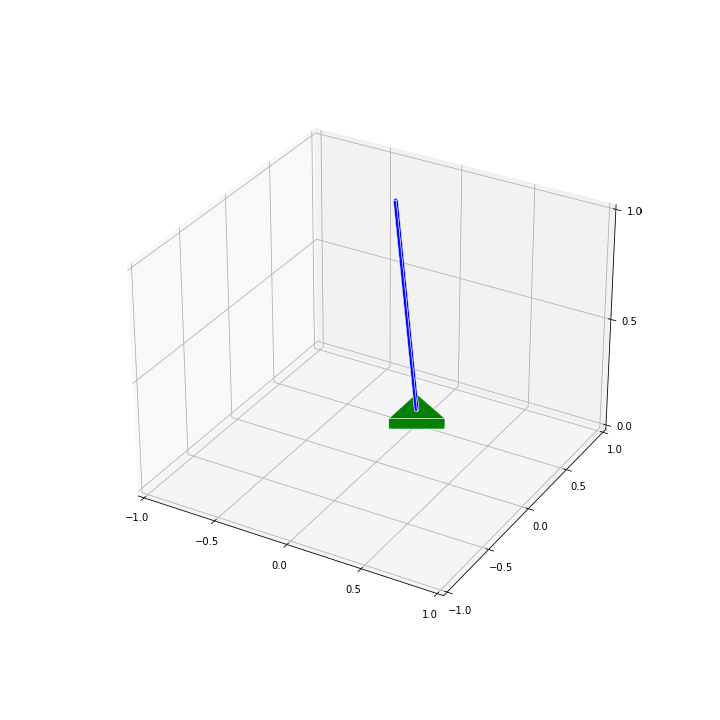

In [58]:
Image(filename='pictures/animation/test1.gif', width=800)